# MLP MNIST Image Classification

## Tasks
* Load and visualize the data
* Define a neural network
* Train the model
* Evaulate the peformance and accuracy on trained model on test dataset



In [11]:
import torch
import numpy as np

## Load and Visualize Sample Data
* Download and setup loaders for training and testing data
* Extract validationd data sample from training data for validation loss monitoring


In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# number of workers for processing and batch load sample size
NUM_WORKERS, BATCH_SIZE = 0, 20
VAL_DATA_PERCENT = 0.2

# image data transformers
transform = transforms.ToTensor()

# pick training and testing datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# apply random sampling technique to set aside validation dataset
train_data_size = len(train_data)
train_data_indices = list(range(train_data_size))
np.random.shuffle(train_data_indices)
val_data_size = int(np.floor(VAL_DATA_PERCENT*train_data_size))
train_idx, val_idx = train_data_indices[val_data_size:], train_data_indices[:val_data_size]



# prepare data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_idx) ,num_workers=NUM_WORKERS)
val_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(val_idx), num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

## Visualize Sample Data
* Check few samples of MNIST data that was downloaded
* This step is to make sure we are working with expected data and formats

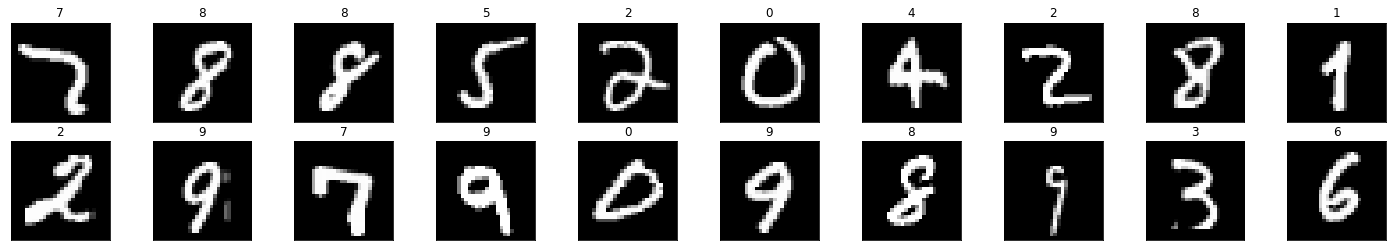

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# check a first batch of data to verfify
# can be random pick as well

train_data_iter = iter(train_loader)
images, labels = train_data_iter.next()
images = images.numpy()

# plot images and their labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))





## Close look at one of the images
* Check closely how pixels are marked on each image

thresh 0.4


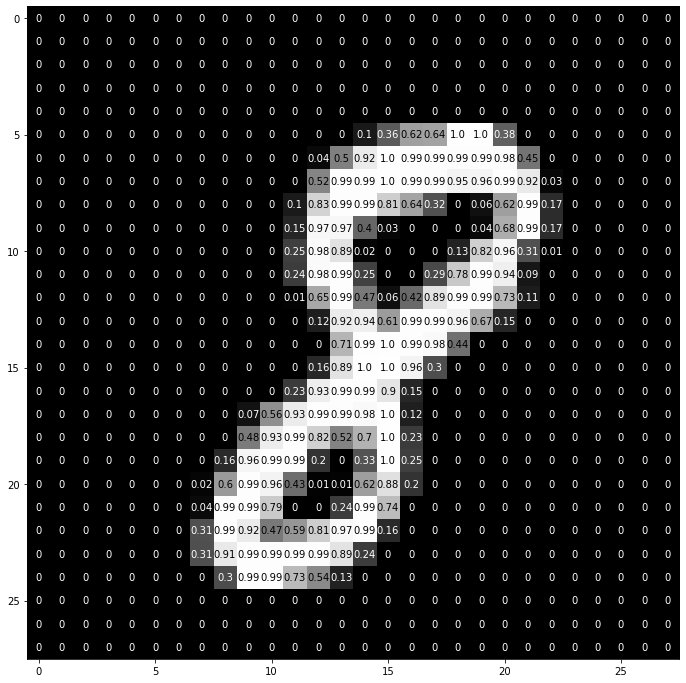

In [18]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
print('thresh', thresh)

for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y]!=0 else 0
        ax.annotate(str(val), xy=(y,x), 
                   horizontalalignment='center', verticalalignment='center',
                   color='white' if img[x][y]<thresh else 'black')


## Define our neural net architecture
* Specify the input and output tensor dimensions and output of 10 class labels
* Instantiate the class

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Keep the scores raw as CrossEntropyLoss is used as criterion
        x = self.fc3(x)
        return x

    
model = Net()
model


Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

## Define Loss Criterion and Optimizer
* Cross Entropy loss applies Softmax activation to raw class scores and uses NLLLoss to calculate loss

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

criterion, optimizer


(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.01
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

---

# Define & Train Model
* Initialize # of epochs
* For each epoch a.k.a training pass
    * Peform a forward pass
    * Calculate iteraion loss and update running losses
    * Perform backward pass to calculate gradients
    * Execute optimizer step to update the network wrights with grads
    * Print training metrics - epoch cycle, training time and running losses

In [30]:
from time import time

NUM_EPOCHS = 50


running_train_loss = 0.0
running_train_time = 0.0

running_val_loss = 0.0
min_val_loss = np.Inf
running_val_time = 0.0

for epoch in range(NUM_EPOCHS):
    print(f'Epoch: {epoch+1} of {NUM_EPOCHS}')
        
    ################## Training Pass #################
    epoch_train_loss = 0.0
    epoch_train_time = 0.0
    model.train() # Turn ON training mode
    for images,labels in train_loader:
        # iteration prep, start with clean gradients
        optimizer.zero_grad()
        
        # forward pass and loss calculations
        t1 = time()
        out = model(images)
        t2 = time()
        
        loss = criterion(out, labels)
        epoch_train_loss += loss.item()
        epoch_train_time += (t2-t1)
        
        # backward pass and update weights
        loss.backward()
        optimizer.step()
        
    train_loss = epoch_train_loss/len(train_loader)
    print(f'Traing losses: {train_loss}')
    print(f'Epoch Traing Time: {round(epoch_train_time, 3)} secs')
    print('--------------------------------------------------------')
    running_train_loss += epoch_train_loss
    running_train_time += epoch_train_time
    
    ############ Validation Pass #############
    epoch_val_loss = 0.0
    epoch_val_time = 0.0
    model.eval() # Switch to evaluation mode
    for images, labels in val_loader:
        t1 = time()
        out = model(images)
        t2 = time()
        
        loss = criterion(out, labels)
        epoch_val_loss += loss.item()
        epoch_val_time += (t2-t1)
    
    val_loss = epoch_val_loss/len(val_loader)
    print(f'Validation losses: {val_loss}')
    print(f'Epoch Validation Time: {round(epoch_val_time, 3)} secs')
    running_val_loss += epoch_val_loss
    running_val_time += epoch_val_time
    
    # Log validation loss stats per epoch
    if val_loss <= min_val_loss:
        print(f'Validation loss decreased by {min_val_loss-val_loss} =  {min_val_loss} --> {val_loss}')
        print(f'Saving model checkpoint')
        torch.save(model.state_dict(), 'model.pt')
        min_val_loss = val_loss
    
    

####### Stats for all training epochs ###########    
print('************************** Training Stats **************************')    
print(f'Total Training Time: {round(running_train_time, 3)} secs for {NUM_EPOCHS} training epochs')


######## Stats for all validation epocs #########
print('************************** Validation Stats **************************') 
print(f'Total Validation Time: {round(running_val_time,3)} secs for {NUM_EPOCHS} validation epochs')



Epoch: 1 of 50
Traing losses: 0.19615540206141305
Epoch Traing Time: 1.504 secs
--------------------------------------------------------
Validation losses: 0.20440066712598007
Epoch Validation Time: 0.383 secs
Validation loss decreased by inf =  inf --> 0.20440066712598007
Saving model checkpoint
Epoch: 2 of 50
Traing losses: 0.16942649057794673
Epoch Traing Time: 1.513 secs
--------------------------------------------------------
Validation losses: 0.18388742880740513
Epoch Validation Time: 0.361 secs
Validation loss decreased by 0.020513238318574933 =  0.20440066712598007 --> 0.18388742880740513
Saving model checkpoint
Epoch: 3 of 50
Traing losses: 0.14863302980355608
Epoch Traing Time: 1.397 secs
--------------------------------------------------------
Validation losses: 0.1657576961667898
Epoch Validation Time: 0.462 secs
Validation loss decreased by 0.018129732640615348 =  0.18388742880740513 --> 0.1657576961667898
Saving model checkpoint
Epoch: 4 of 50
Traing losses: 0.1320289367

Validation losses: 0.08009031510191562
Epoch Validation Time: 0.355 secs
Epoch: 28 of 50
Traing losses: 0.01630232113051534
Epoch Traing Time: 1.419 secs
--------------------------------------------------------
Validation losses: 0.07974817675744514
Epoch Validation Time: 0.357 secs
Epoch: 29 of 50
Traing losses: 0.015044338688876452
Epoch Traing Time: 1.427 secs
--------------------------------------------------------
Validation losses: 0.07885422684858592
Epoch Validation Time: 0.348 secs
Validation loss decreased by 0.0008528899499894299 =  0.07970711679857535 --> 0.07885422684858592
Saving model checkpoint
Epoch: 30 of 50
Traing losses: 0.013852602467789741
Epoch Traing Time: 1.417 secs
--------------------------------------------------------
Validation losses: 0.07989811782107911
Epoch Validation Time: 0.346 secs
Epoch: 31 of 50
Traing losses: 0.013053893293775522
Epoch Traing Time: 1.414 secs
--------------------------------------------------------
Validation losses: 0.0780342810

## Plot Losses
* Training, Validation & Testing losses

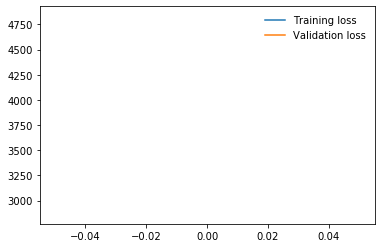

In [36]:
# To plot losses, need to capture losses as arrays
plt.plot(running_train_loss, label='Training loss')
plt.plot(running_val_loss, label='Validation loss')
plt.legend(frameon=False)



## Load last saved model into context
>Note: The last saved model will have minimum validation loss among epochs 

In [37]:
model.load_state_dict(torch.load('model.pt'))
model

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

## Test Trained Model
* Switch model to eval mode to avoid dropouts and other grad flags
* This is achieved using `model.eval()`

In [38]:

def print_shape(t, msg):
    print(f'shape of {msg} tensor: {t.shape}')


model.eval()
running_test_loss = 0.0
running_test_time = time()
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for images, labels in test_loader:
    out = model(images)    
    loss = criterion(out, labels)
    running_test_loss += loss.item()
    _, pred_top_class = torch.max(out, 1)
    correct = np.squeeze(pred_top_class.eq(labels.data.view_as(pred_top_class)), axis=0) 
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

running_test_time = time() - running_test_time        
print(f'class_correct = {class_correct}')
print(f'class_total = {class_total}')
print(f'Total Test Loss: {running_test_loss/len(test_loader)}')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {i}: {round(100*class_correct[i]/class_total[i], 2)}, {np.sum(class_correct[i])}, {np.sum(class_total[i])}')
    else:
        print(f'Test Accuracy of {i}: N/A (no training examples)')
              
print(f'\nTest Accuracy (Overall): {100.*np.sum(class_correct)/np.sum(class_total)}, {np.sum(class_correct)}, {np.sum(class_total)}')

    


class_correct = [968.0, 1124.0, 1012.0, 988.0, 959.0, 870.0, 940.0, 1002.0, 949.0, 981.0]
class_total = [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0]
Total Test Loss: 0.06618494862555963
Test Accuracy of 0: 98.78, 968.0, 980.0
Test Accuracy of 1: 99.03, 1124.0, 1135.0
Test Accuracy of 2: 98.06, 1012.0, 1032.0
Test Accuracy of 3: 97.82, 988.0, 1010.0
Test Accuracy of 4: 97.66, 959.0, 982.0
Test Accuracy of 5: 97.53, 870.0, 892.0
Test Accuracy of 6: 98.12, 940.0, 958.0
Test Accuracy of 7: 97.47, 1002.0, 1028.0
Test Accuracy of 8: 97.43, 949.0, 974.0
Test Accuracy of 9: 97.22, 981.0, 1009.0

Test Accuracy (Overall): 97.93, 9793.0, 10000.0


# Evaluate/Visualize
* View sample test results
* This helps check how good our model is performing on data that it hasn't before


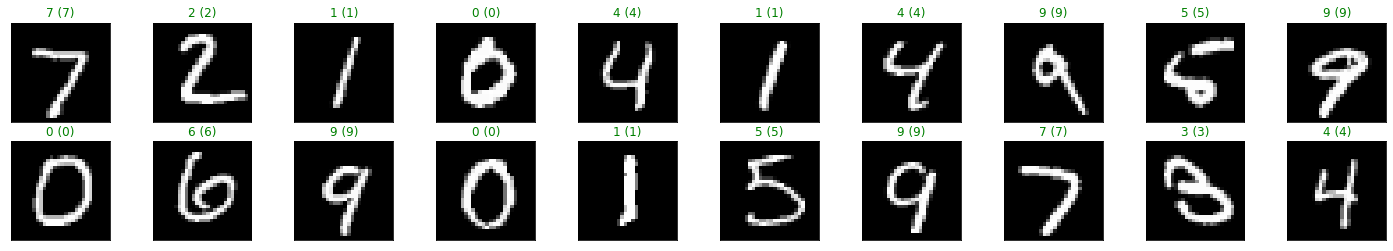

In [39]:
test_viz_iter = iter(test_loader)
images, labels = test_viz_iter.next()

out = model(images)
_, preds = torch.max(out, 1)

images = images.numpy()
fig = plt.figure(figsize=(25,4))
for idx in range(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(f'{preds[idx].item()} ({labels[idx].item()})', 
                 color=('green' if preds[idx]==labels[idx] else 'red'))


